In [1]:
sub_categories = ["Gift_Cards", "Magazine_Subscriptions"]

In [2]:
from datasets import load_dataset

review_datasets_list = []
meta_dataset_list = []
for sub_cat in sub_categories:
    print(f"Loading review dataset for sub category {sub_cat}")
    sub_cat_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_review_{sub_cat}", split="full", trust_remote_code=True)
    review_datasets_list.append(sub_cat_dataset.add_column('category', [sub_cat]*len(sub_cat_dataset)))
    
    print(f"Loading metadata dataset for sub category {sub_cat}")
    sub_cat_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_{sub_cat}", split="full", trust_remote_code=True)
    meta_dataset_list.append(sub_cat_dataset)

Loading review dataset for sub category Gift_Cards
Loading metadata dataset for sub category Gift_Cards
Loading review dataset for sub category Magazine_Subscriptions
Loading metadata dataset for sub category Magazine_Subscriptions


In [3]:
from datasets import concatenate_datasets

In [4]:
review_dataset = concatenate_datasets(review_datasets_list)
meta_dataset = concatenate_datasets(meta_dataset_list)
meta_dataset = meta_dataset.rename_column("title", "item_title")

In [5]:
meta_df = meta_dataset.to_pandas()
review_df = review_dataset.to_pandas()

In [6]:
review_selected_cols = ["rating", "title", "text", "parent_asin", "user_id", "timestamp", "helpful_vote", "verified_purchase", "category"]
meta_selected_cols = ["main_category", "item_title", "average_rating", "rating_number", "features", "description", "price", "store", "categories", "details", "parent_asin"]
merge_df = review_df[review_selected_cols].merge(meta_df[meta_selected_cols], on="parent_asin")

In [7]:
merge_df["title_text"] = merge_df.apply(lambda x: f"{x['title']} {x['text']}".lower(), axis=1)

In [8]:
from datasets.features import Value, Sequence, Features

features = Features({
     'rating': Value(dtype='float64', id=None),
     'title': Value(dtype='string', id=None),
     'title_text': Value(dtype='string', id=None),
     'text': Value(dtype='string', id=None),
     'parent_asin': Value(dtype='string', id=None),
     'user_id': Value(dtype='string', id=None),
     'timestamp': Value(dtype='int64', id=None),
     'helpful_vote': Value(dtype='int64', id=None),
     'verified_purchase': Value(dtype='bool', id=None),
     'main_category': Value(dtype='string', id=None),
     'category': Value(dtype='string', id=None),
     'item_title': Value(dtype='string', id=None),
     'average_rating': Value(dtype='float64', id=None),
     'rating_number': Value(dtype='int64', id=None),
     'features': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'description': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'price': Value(dtype='string', id=None),
     'store': Value(dtype='string', id=None),
     'categories': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
     'details': Value(dtype='string', id=None)})

In [9]:
from datasets import Dataset, concatenate_datasets
from tqdm.notebook import tqdm

chunk_size = 5000  # Adjust this based on your memory capacity
datasets_list = []

for i in tqdm(range(0, len(merge_df), chunk_size)):
    chunk = merge_df.iloc[i:i + chunk_size]
    datasets_list.append(Dataset.from_pandas(chunk, features))

# Concatenate all chunks into one dataset
final_dataset = concatenate_datasets(datasets_list)

  0%|          | 0/45 [00:00<?, ?it/s]

In [10]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from umap import UMAP
import datasets
import numpy as np
import torch

datasets.logging.set_verbosity_error()

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(SEED)

In [11]:
from sentence_transformers import SentenceTransformer

transformer = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
raw_texts = final_dataset["title_text"]
embeddings = transformer.encode(raw_texts)

/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
category = "Magazine_Subscriptions"
cat_dataset = final_dataset.filter(lambda row: row["category"] == category)

Filter:   0%|          | 0/223907 [00:00<?, ? examples/s]

In [17]:
import random

n_samples = len(cat_dataset)
n_samples_train = round(n_samples * 0.8)
train_indices = random.sample(range(n_samples), n_samples_train)
test_indices = list(set(range(n_samples)) - set(train_indices))
X_train = embeddings[train_indices, :]
X_test = embeddings[test_indices, :]

In [27]:
train_df = cat_dataset.to_pandas().loc[train_indices]
test_df = cat_dataset.to_pandas().loc[test_indices]

In [18]:
from cleanlab.outlier import OutOfDistribution

# Get outlier scores for each of the data feature embeddings
ood = OutOfDistribution()
ood.fit(features=X_train)

Fitting OOD estimator based on provided features ...


In [22]:
ood_test_scores = ood.score(features=X_test)

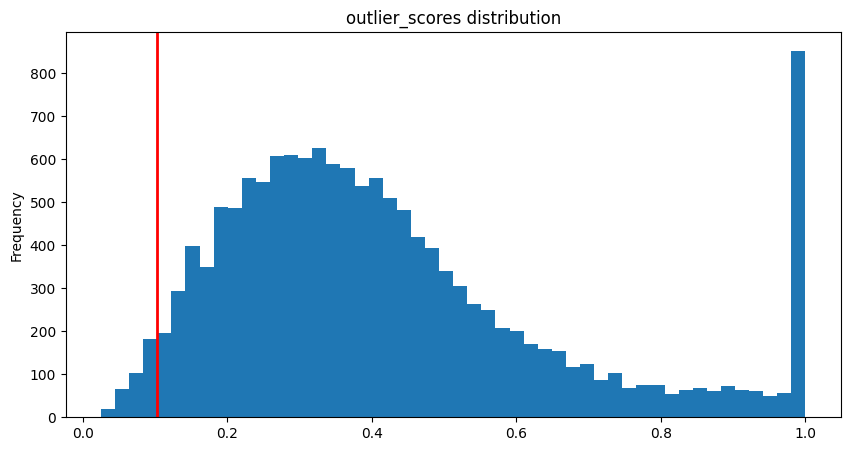

In [24]:
import matplotlib.pyplot as plt

threshold = np.percentile(ood_test_scores, 2.5)

fig, axe = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
plt_range = [ood_test_scores.min(), ood_test_scores.max()]

axe.hist(ood_test_scores, range=plt_range, bins=50)
axe.set(title='outlier_scores distribution', ylabel='Frequency')
axe.axvline(x=threshold, color='red', linewidth=2)

In [31]:
test_df["outlier_score"] = ood_test_scores
test_df["outlier"] = ood_test_scores < threshold
test_df

,rating,title,title_text,text,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,...,average_rating,rating_number,features,description,price,store,categories,details,outlier_score,outlier
0,5.0,Great pictures and recipes,great pictures and recipes wonderful recipes i...,Wonderful recipes in this magazine.,B00HLSSQKK,AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ,1608046142433,0,True,Magazine Subscriptions,...,4.6,538,[],[],None,Hoffman Media Inc,"[Magazine Subscriptions, Cooking, Food & Wine,...","{""Date First Available"": ""December 30, 2013""}",0.473475,False
32768,4.0,quick meals,quick meals to the point recipes,to the point recipes,B0061SHL48,AFQBVYM6IWKJZVEUX2ZLFUQ3ZLYQ,1538580572766,0,True,Magazine Subscriptions,...,4.3,340,[],"[Packed with easy meals for busy people, Simpl...",None,"Trusted Media Brands, Inc.","[Magazine Subscriptions, Cooking, Food & Wine,...","{""Date First Available"": ""November 1, 2011"", ""...",0.486042,False
65536,5.0,"Ordered as gift, but enjoying it myself","ordered as gift, but enjoying it myself i orde...",I ordered this magazine as a gift for my husba...,B000LXHJEQ,AEEFXNBBCFYVPSSAB4B63F7OPLDQ,1296101443000,2,True,Magazine Subscriptions,...,3.0,76,[],[],None,None,"[Magazine Subscriptions, Professional & Educat...","{""Date First Available"": ""April 12, 2023""}",0.095496,True
65537,5.0,Love mag confused about out come of ordering.,love mag confused about out come of ordering. ...,I have always loved artist magazine. although...,B0047VIAMS,AFHOV6ICXY2ZJUNPLVQCIN5SNUYQ,1395847314000,0,True,Magazine Subscriptions,...,4.4,450,[],[],None,Peak Media,"[Magazine Subscriptions, Arts, Music & Photogr...","{""Date First Available"": ""October 20, 2010""}",0.286774,False
4,1.0,Too many “ gear ads” !!,too many “ gear ads” !! too many ads!,Too many ads!,B0025ZOVEO,AFUB7CHTXRPD447QVQCHBZVN2IPQ,1591046680246,13,True,Magazine Subscriptions,...,4.3,355,[],"[Product Description, Outside covers the excit...",None,Outside,"[Magazine Subscriptions, Sports, Recreation & ...","{""Date First Available"": ""April 8, 2009"", ""Man...",0.253143,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32753,5.0,Great magazine and great value.,great magazine and great value. we love this m...,"We love this magazine, and it was a great deal...",B0037STB02,AEUAISFWUPPLIS3TX5ITY23QXNFA,1578946890856,0,True,Magazine Subscriptions,...,4.3,1784,[],"[Amazon.com Review, Entertainment Weekly Magaz...",None,Meredith Corporation,"[Magazine Subscriptions, Entertainment & Pop C...","{""Date First Available"": ""September 25, 2014"",...",0.484076,False
65528,5.0,Five Stars,five stars i look forward to it every month.,I look forward to it every month.,B001THPA58,AEARRYYS45GSR7D7DE64IV2T42HA,1517205539734,0,True,Magazine Subscriptions,...,4.6,13511,[],[],None,Hearst Magazines,"[Magazine Subscriptions, Cooking, Food & Wine,...",{},0.348377,False
32763,5.0,Like it a lot,like it a lot like it a lot,Like it a lot,B003K195Y8,AHRSNE3XFRO45J4XAR6SI2PBVVNA,1575957716633,0,True,Magazine Subscriptions,...,4.6,598,[],[],None,Outdoor Sportsman Group - Integrated Media,"[Magazine Subscriptions, Sports, Recreation & ...","{""Date First Available"": ""May 1, 2010""}",0.439652,False
32764,5.0,good magazine for kids,good magazine for kids good reading for kids,good reading for kids,B002PXW1R0,AGMX42L7YVLZGTLXFXXIM2PCOOSQ,1638590694679,0,True,Magazine Subscriptions,...,4.7,17309,[],[],None,National Geographic Partners LLC,"[Magazine Subscriptions, Children & Teen, Chil...","{""Date First Available"": ""September 22, 2009""}",0.266982,False


/Users/mouhaned.chebaane/Library/Caches/pypoetry/virtualenvs/abwab-homework-r5ZhboOE-py3.11/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


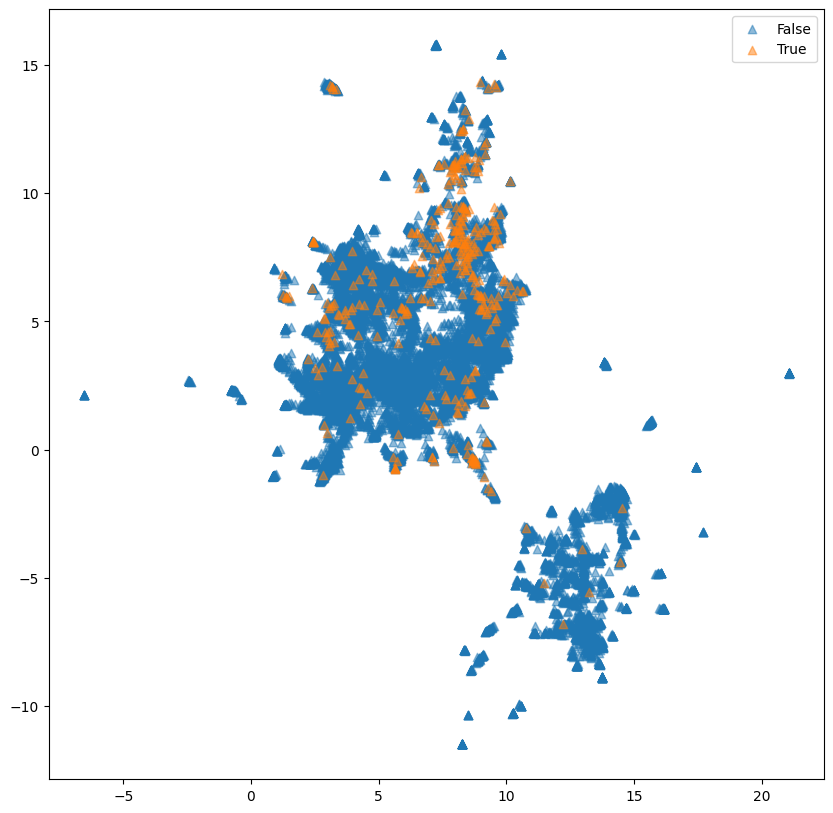

In [33]:
# Reduce dimensionality with UMAP
umap_fit = UMAP(n_components=2, n_neighbors=8, random_state=SEED)
test_embeddings_umap = umap_fit.fit_transform(X_test)

# Set plot labels
outlier_preds = test_df["outlier"].values

# Plot reduced embeddings
plt.figure(figsize=(10, 10))
x_plot, y_plot = test_embeddings_umap[:, 0], test_embeddings_umap[:, 1]

for i, pred in enumerate(set(outlier_preds)):
    x, y = x_plot[outlier_preds == i], y_plot[outlier_preds == i]
    plt.scatter(x, y, label=pred, alpha=0.5, marker="^")
plt.legend()